In [1]:
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from pricing.transformer import RareCategoryGrouper


In [2]:
def wykres_dla_modelu(y_pred_test, y_pred_train, title):
    
    print(f"MSE - zbiór uczący: {mean_squared_error(y_train, y_pred_train)}")
    print(f"R^2 - zbiór uczący: {r2_score(y_train, y_pred_train)}")
    print(f"MSE - zbiór testowy: {mean_squared_error(y_test, y_pred_test)}")
    print(f"R^2 - zbiór testowy: {r2_score(y_test, y_pred_test)}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_pred_train, color='red', edgecolor='black', alpha=0.2)
    plt.scatter(y_test, y_pred_test, color='deepskyblue', edgecolor='black', alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.grid(axis='x', linestyle=':', alpha=0.7)
    plt.xlabel("Rzeczywista cena")
    plt.ylabel("Przewidywana cena")
    plt.title(title)
    plt.show()
    
    

MSE - zbiór uczący: 77542198.60731648
R^2 - zbiór uczący: 0.9268449359232872
MSE - zbiór testowy: 157220956.17925566
R^2 - zbiór testowy: 0.8629317704936196


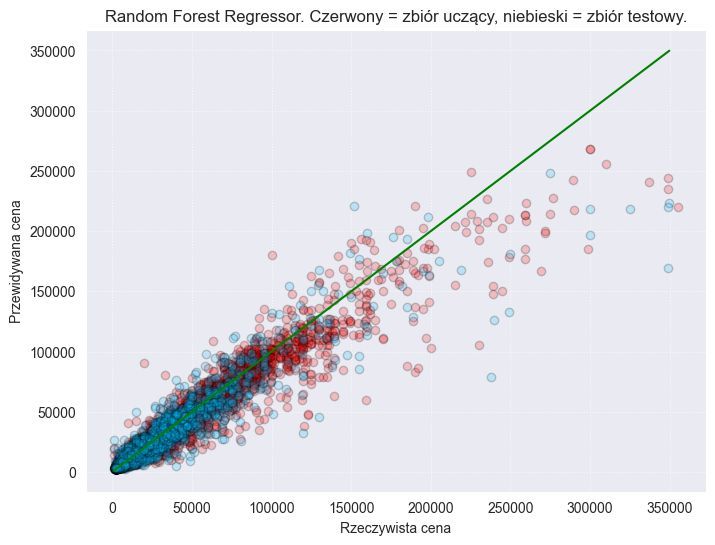

In [3]:
cat_cols = ['Model', 'Paliwo', 'Typ nadwozia', 'Kolor', 'Skrzynia biegów', 
            'Kraj pochodzenia', 'Napęd', 'Kierownica', 'Województwo', 
            'Rodzaj ogłoszenia', 'Producent']
preprocess = Pipeline([
    ('rare_producent', RareCategoryGrouper('Producent', min_count=10)),
    ('rare_kraj', RareCategoryGrouper('Kraj pochodzenia', min_count=15)),
    ('onehot', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('column_dropper', 'drop', "Przebieg")
        ],
        remainder='passthrough'
    )),
])
regressor = TransformedTargetRegressor(
    regressor=RandomForestRegressor(max_depth = 15, min_samples_leaf = 4, min_samples_split = 10, n_estimators =200),
    func=np.log,
    inverse_func=np.exp
)
full_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('regressor', regressor)
])
df = pd.read_csv("../datasets/cars_cleaned.csv")    
x = df.drop(columns=["Cena"])
y = df["Cena"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
full_pipeline.fit(x_train, y_train)
y_pred_train = full_pipeline.predict(x_train)
y_pred_test = full_pipeline.predict(x_test)
wykres_dla_modelu(y_pred_test, y_pred_train, "Random Forest Regressor. Czerwony = zbiór uczący, niebieski = zbiór testowy.")



Model wykazuje pewne przeuczenie, a w przypadku obu zbiorów istnieje lekka tendencja do zaniżania wyceny.

In [4]:
full_pipeline.fit(x, y)
joblib.dump(full_pipeline, "model_pipeline.joblib")

['model_pipeline.joblib']